# Perso

In [115]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torchvision.models as models
from PIL import Image
from torchvision.transforms import ToTensor
import json
import pickle
import numpy as np
from copy import deepcopy
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch
from flashtorch.activmax import GradientAscent
import flashtorch
from flashtorch.activmax import GradientAscent
from flashtorch.utils import standardize_and_clip,format_for_plotting
import torch.nn as nn

img_path="./flashtorch/tinyimagenet/train/n01443537/images/n01443537_1.JPEG"
image = Image.open(img_path)
image = ToTensor()(image).unsqueeze(0)

In [2]:
model = models.vgg16(pretrained=True)
g_ascent = GradientAscent(model.features)


In [3]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

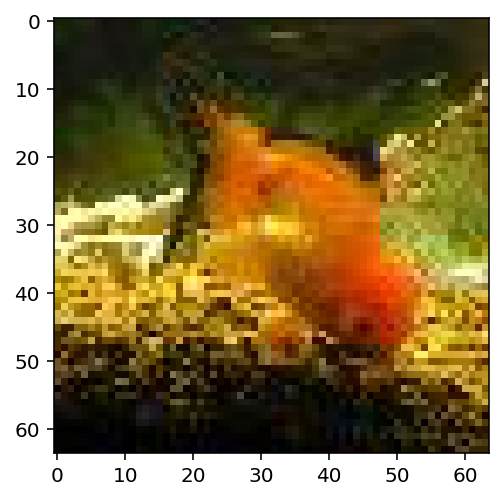

In [4]:
plt.imshow(image[0].permute(1,2,0))

In [5]:
test_paths = ["img_folder/test{}.JPEG".format(i+1) for i in range(9)]

In [6]:
#number of favourites images per filter
N_FAV = 4

In [82]:
def build_model(model):
    model_info = []
    #construct the data structure
    for layer in list(model.features.named_children()):
        layer_dic = {'ind':layer[0],
                  'lay':layer[1],
                  'name':str(layer[1]).split('(')[0] + "_" + str(layer[0]) 
                }
        if (type(layer_dic['lay']) == nn.Conv2d):     
            n_input = layer_dic['lay'].in_channels
            n_output = layer_dic['lay'].out_channels
            layer_dic['n_input'] = n_input
            layer_dic['n_output'] = n_output
            layer_dic["filters"] = []
            for i in range(n_output):
                layer_dic["filters"].append({
                    "id":i,
                    "fav_imgs":["./flashtorch/tinyimagenet/numb.jpg" for i in range(N_FAV)],
                    "spikes":[0 for i in range(N_FAV)],
                    "actmax_im":"./img_folder/max_activ/numb_actmax.png"
                })
        elif (type(layer_dic['lay']) == nn.Linear):
                n_input = layer_dic['lay'].in_features
                n_output = layer_dic['lay'].out_features
                layer_dic['n_output'] = n_output
                #layer_dic["filters"] = [empty_filter.copy() for i in range(n_output)]
        model_info.append(layer_dic)
    return model_info

In [113]:
def update_filters_favim(lay_info,spikes,img_path):
    assert(spikes.shape[0] == len(lay_info["filters"]))
    for (filt,spike) in zip(lay_info["filters"],spikes.detach().numpy()):
        #compute the minimum spike for the filter
        min_indx = np.argmin(filt["spikes"])
        min_spike = min(filt["spikes"])
        if (spike > min_spike):
            filt["fav_imgs"][min_indx] = img_path
            filt["spikes"][min_indx] = float(spike)
            
def get_filt_string(layer_name,filter_id):
    return "./img_folder/max_activ/{0}_{1}.png".format(layer_name,filter_id)
                  
def update_layers(model_info,img_paths):                  
    for img_path in img_paths:
        image = Image.open(img_path)
        image = ToTensor()(image).unsqueeze(0)
        im = image
        for lay_info in model_info:
            #TODO:remove squeeze if many images at once
            new_im = lay_info['lay'](im).squeeze()
            spikes = new_im.view(new_im.size(0),-1).norm(dim=1)
            if "filters" in lay_info:
                update_filters_favim(lay_info,spikes,img_path)
            im = new_im.unsqueeze(0) 
    #save the model_info
    for lay_info in model_info:
        if (type(lay_info['lay']) == nn.Conv2d):
            #load imgs: check for their presence
            for filt in lay_info['filters']:
                filt_str = get_filt_string(lay_info["name"],filt["id"])
                try:
                    f = open(filt_str)
                    filt["actmax_im"] = filt_str
                    f.close()
                except FileNotFoundError:
                    pass
                    #print("File not accessible in {}".format(filt_str))                    
def save_to_json(model_info):
    model_info2 = deepcopy(model_info)
    for lay_info in model_info2:
         #TODO: sort the output
        """
        if type(lay_info['lay'] == nn.Conv2d):
            for filt in lay_info["filters"]:
                order = np.argsort(filt["spikes"])[::-1]
                filt["spikes"] = filt["spikes"][order]
                filt["fav_imgs"] = filt["fav_imgs"][order]
        """
        del lay_info['lay']
    with open('saved_model/test_model.json', 'w') as fout:
        json.dump(model_info2, fout, indent = 2)
    print("done!") 

In [114]:
model_info = build_model(model)
update_layers(model_info,test_paths)
save_to_json(model_info)

done!


In [8]:
# last convolutional layer
test_layinfo = model_info[-3]

In [9]:
def compute_imgs_model(model_info):
    for lay_info in model_info:
        if (type(lay_info["lay"]) == nn.Conv2d):
            compute_imgs_layer(lay_info)

            
def compute_imgs_layer(lay_info,indexes = None):
    if indexes is None:
        indexes = range(lay_info["lay"].out_channels)
    layer_name = lay_info["name"]
    pre_existing = []
    for filt in lay_info["filters"]:
        filt_str = get_filt_string(lay_info["name"],filt["id"])
        try:
            f = open(filt_str)
            pre_existing.append(filt["id"])
        except FileNotFoundError:
            pass
    
    indexes = [i for i in indexes if i not in pre_existing]
    act_max_imgs = g_ascent.visualize(lay_info["lay"], indexes, title='conv5_1',return_output=True);
    
    write_images(act_max_imgs,layer_name,indexes)
    
def write_images(imgs,layer_name,indexes):
    for ind,img in zip(indexes,imgs):
        file_name = get_filt_string(layer_name,ind)
        p= standardize_and_clip(img.squeeze(0),saturation = 0.15,brightness = 0.7)
        save_image(p,file_name)

In [10]:
compute_imgs_layer(test_layinfo,[0,14,16])

## Example from the flash torch repo

In [473]:
conv1_2 = model.features[2]
conv1_2_filters = [17, 33, 34, 57]

conv2_1 = model.features[5]
conv2_1_filters = [27, 40, 68, 73]

conv3_1 = model.features[10]
conv3_1_filters = [31, 61, 147, 182]

conv4_1 = model.features[17]
conv4_1_filters = [238, 251, 338, 495]

conv5_1 = model.features[24]
conv5_1_filters = [45, 287, 363, 511]

g_ascent = GradientAscent(model.features)

m = g_ascent.visualize(model_info[-3]["lay"],[] , title='conv5_1',return_output=True);

plt.imshow(format_for_plotting(standardize_and_clip(m[0][29],saturation = 0.15,brightness = 0.7)))

CPU times: user 16min 58s, sys: 3min 7s, total: 20min 6s
Wall time: 8min 21s


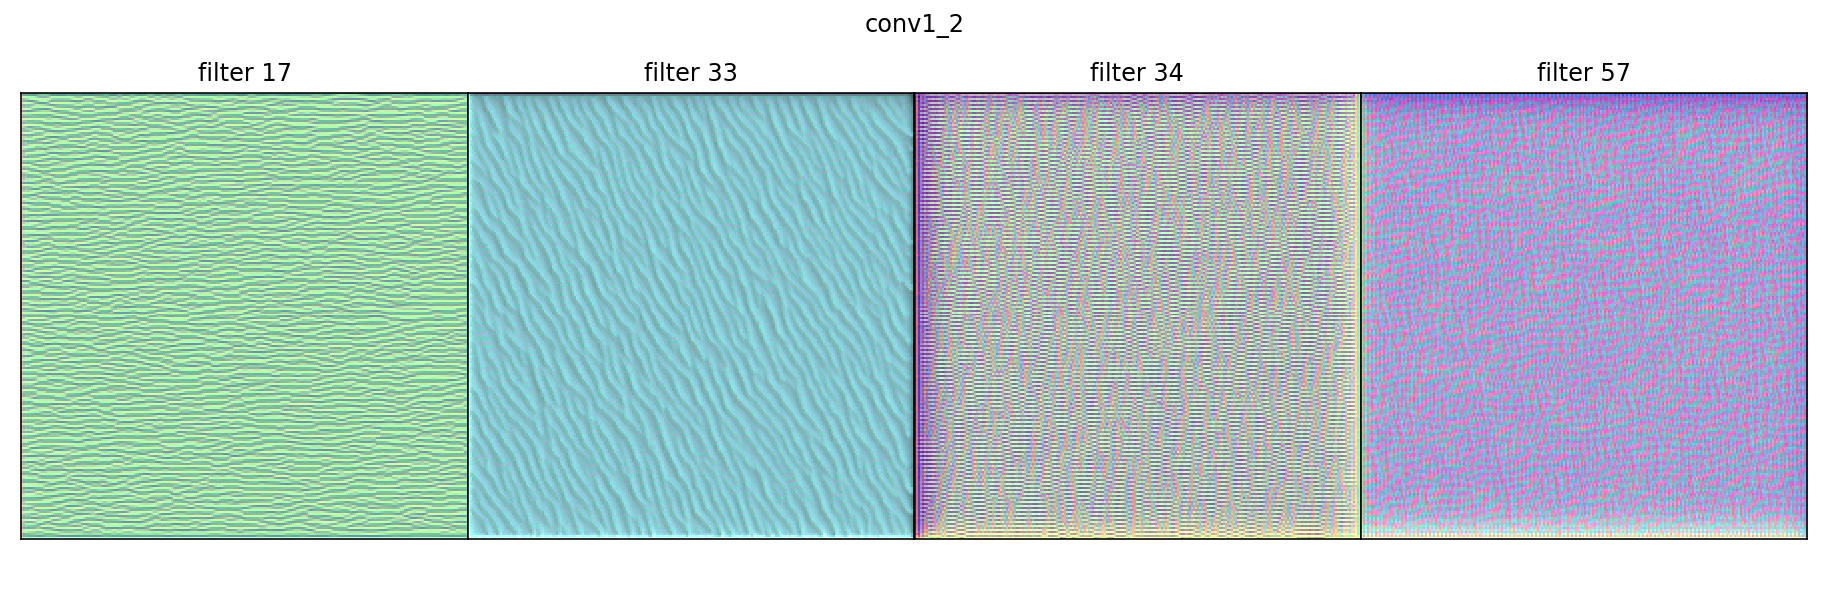

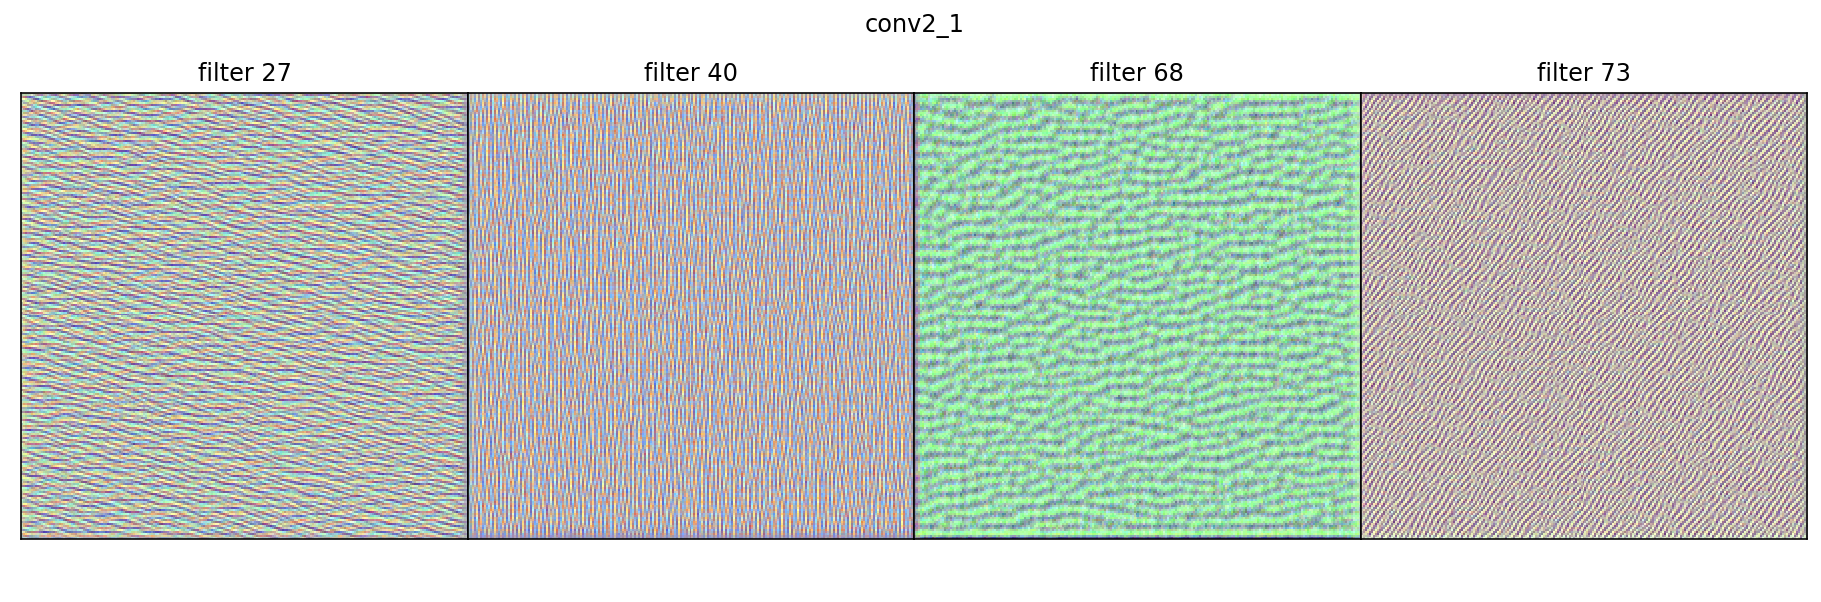

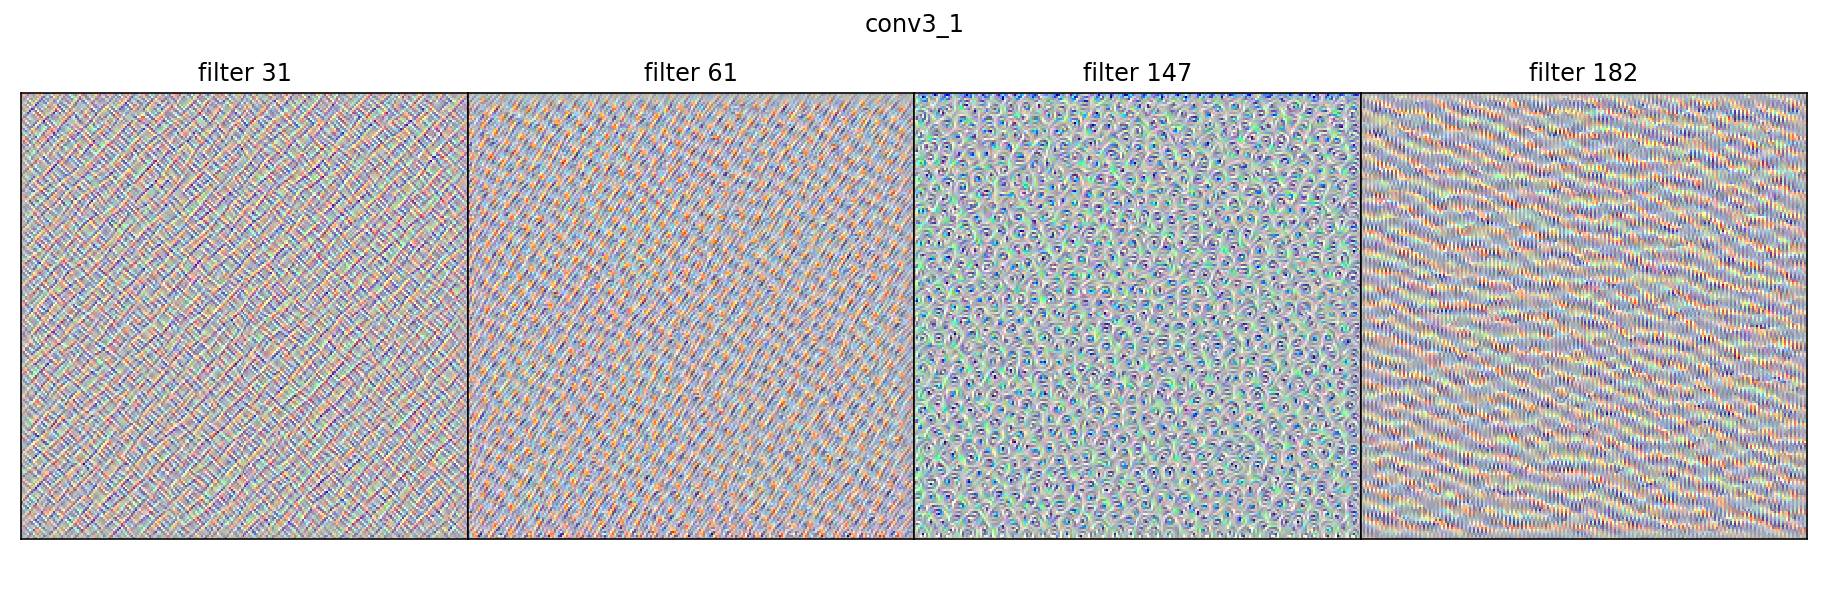

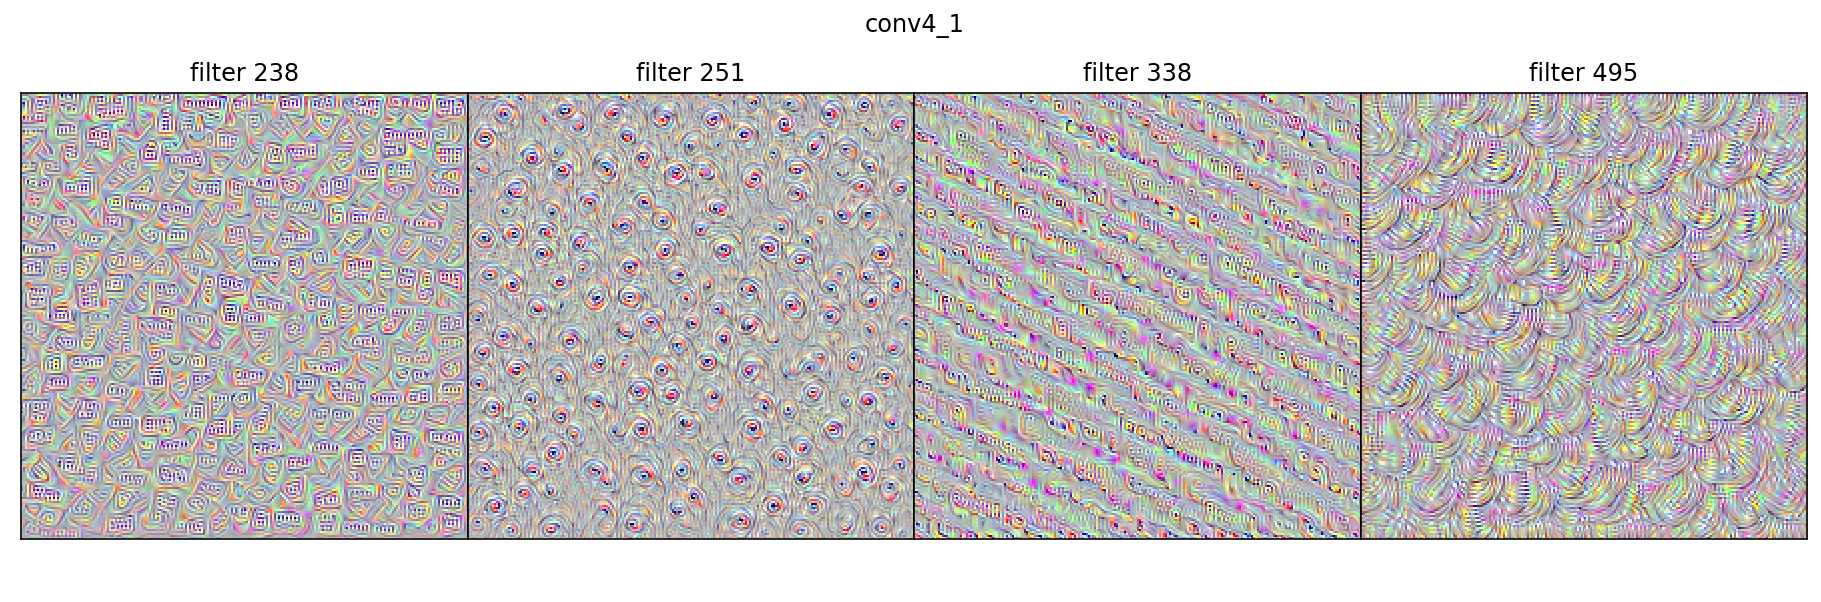

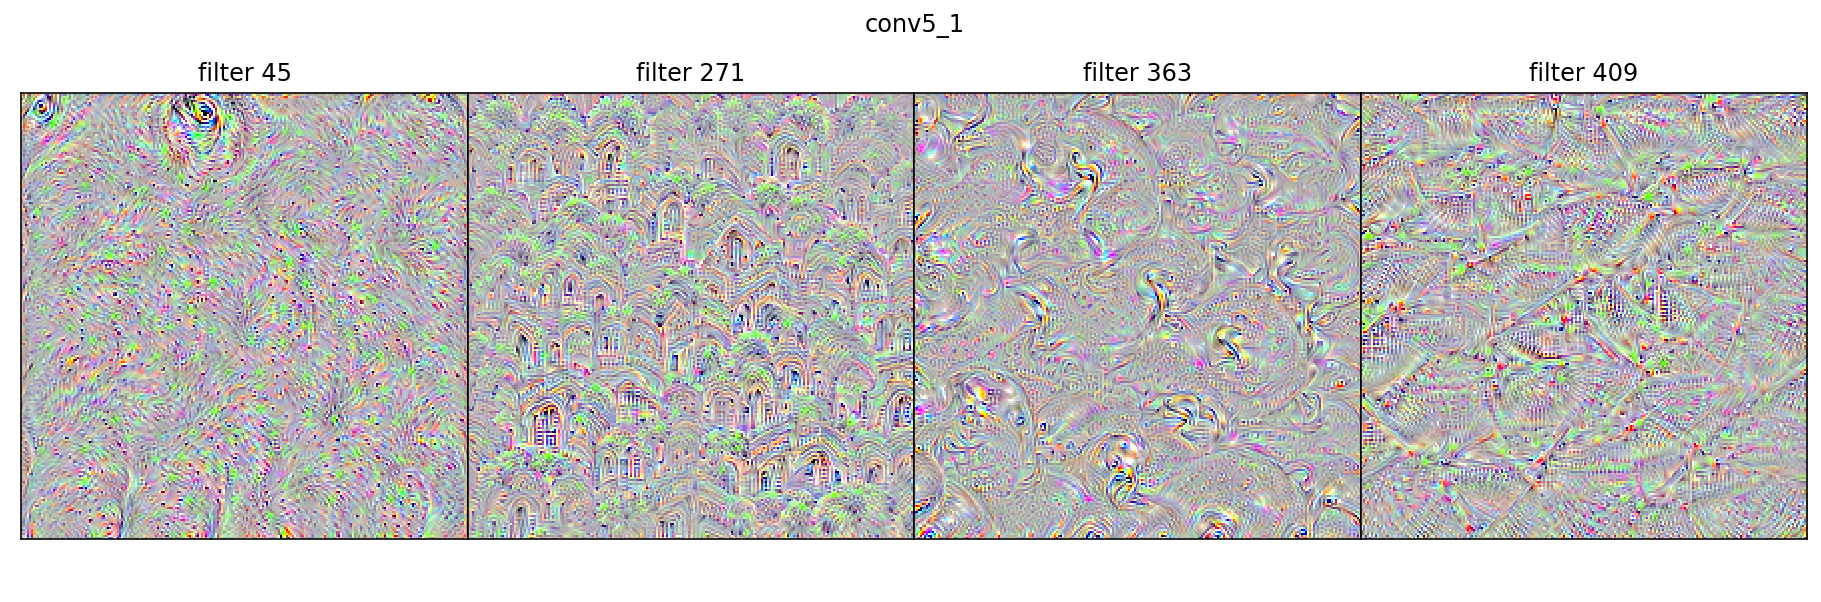

In [10]:
%%time
g_ascent.visualize(conv1_2, conv1_2_filters, title='conv1_2');
g_ascent.visualize(conv2_1, conv2_1_filters, title='conv2_1');
g_ascent.visualize(conv3_1, conv3_1_filters, title='conv3_1');
g_ascent.visualize(conv4_1, conv4_1_filters, title='conv4_1');
g_ascent.visualize(conv5_1, conv5_1_filters, title='conv5_1');